# As Viradas do Brasileirão

O Campeonato Brasileiro é uma das competições de futebol mais emocionantes e imprevisíveis do país. Ao longo dos anos, testemunhamos diversas viradas impressionantes, momentos em que equipes conseguiram reverter desvantagens e alcançar resultados surpreendentes. No presente trabalho, mergulharemos na história das viradas do Brasileirão, utilizando dados para examinar os elementos-chave por trás dessas reviravoltas.

<center> 
<div>
<img src="https://tntsports.com.br/__export/1638496760115/sites/esporteinterativo/img/2021/12/02/galo_1.jpg_554688468.jpg" width="600"/>
</div>
(Foto por: http://bit.ly/3Nza3dg) </center> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator


color_lst = ['#e3d000', '#02b508', '#0850c4']

#plt.style.use('dark_background')

custom_plot = {'font.serif':'Computer Modern Roman',
               'font.size': 14, 
               'axes.grid.which': 'both',
               'grid.linestyle': '--',
               'ytick.minor.size':4,
               'ytick.major.size':10,
               'lines.markersize': 10.0,
              }

mpl.rcParams.update(custom_plot)

## 1. Entendendo o Banco de Dados

Antes de levantarmos qualquer análise, devemos entender nosso banco de dados e suas planilhas, para evitarmos qualquer equívoco. Temos quatro planilhas: cartão, estatísticas, partidas e gols.   

In [2]:
df_1 = pd.read_csv('campeonato-brasileiro-cartoes.csv')
df_2 = pd.read_csv('campeonato-brasileiro-estatisticas-full.csv')
df_3 = pd.read_csv('campeonato-brasileiro-full.csv')
df_4 = pd.read_csv('campeonato-brasileiro-gols.csv')

df_3 = df_3.rename(columns = {'ID': 'partida_id'})


Os registros das partidas se iniciaram em 2003. Porém, os gols e o momento em que ocorreram começam a ser registrados a partir da 4067º partida. Isso é essencial para dizer se uma partida foi ganha por virada ou não. Portanto, nossa análise fica limitada a partir da data em que ocorreu tal partida.

In [3]:
ini_gols = df_3.loc[df_3['partida_id'] == 4607, 'data'].iat[0]

print(f'Início do registro de gols e faltas: {ini_gols}')

Início do registro de gols e faltas: 19/4/2014


In [4]:
fim = df_3.loc[:, 'data'].iat[-1]

print(f'Fim dos registros das partidas: {fim}')

Fim dos registros das partidas: 13/11/2022


Assim, nossa análise fica limitada ao período entre 19/4/2014 e 13/11/2022.

In [5]:
drop_3 = df_3['partida_id'] < 4607
drop_2 = df_2['partida_id'] < 4607


df_3 = df_3.drop(df_3[drop_3].index)
df_2 = df_2.drop(df_2[drop_2].index)

## 2. Lidando com Dados Faltantes

Vamos verificar se há dados faltantes e como eles se distribuem em nosso conjunto de dados.

In [6]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419 entries, 4606 to 8024
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   partida_id          3419 non-null   int64 
 1   rodata              3419 non-null   int64 
 2   data                3419 non-null   object
 3   hora                3419 non-null   object
 4   mandante            3419 non-null   object
 5   visitante           3419 non-null   object
 6   formacao_mandante   3051 non-null   object
 7   formacao_visitante  3051 non-null   object
 8   tecnico_mandante    3415 non-null   object
 9   tecnico_visitante   3415 non-null   object
 10  vencedor            3419 non-null   object
 11  arena               3419 non-null   object
 12  mandante_Placar     3419 non-null   int64 
 13  visitante_Placar    3419 non-null   int64 
 14  mandante_Estado     3419 non-null   object
 15  visitante_Estado    3419 non-null   object
dtypes: int64(4), object(1

Há 4 registros de técnicos faltantes e 368 registros de formação faltantes. Em razão do número baixo de dados faltantes, podemos ignorar qualquer complexidade que os registros dos técnicos faltantes podem trazer. O de formação, no entanto, não pode ser ignorado. Tal fato deve ser investigado mais a fundo.

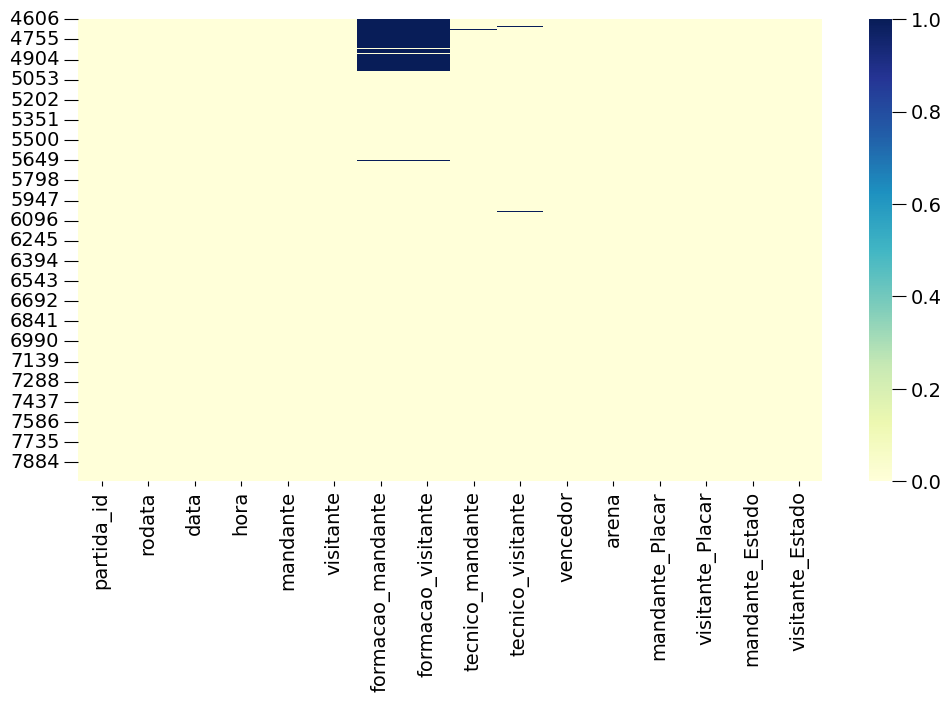

In [7]:
plt.figure(figsize = (12, 6))
sns.heatmap(df_3.isnull(),cmap='YlGnBu');

Não há registros iniciais da formação, seja mandante ou visitante, levando um tempo para se tornar consistente. Dessa forma, qualquer análise que leve em conta a formação só pode ser considerada válida após a data em que se iniciou os registros.

In [8]:
df_3.loc[df_3['formacao_mandante'].isnull(), 'data'].tail(10)

# 7/12/2014

4980     7/12/2014
4981     7/12/2014
4982     7/12/2014
4983     7/12/2014
4984     7/12/2014
4985     7/12/2014
5409      1/6/2016
5651     6/10/2016
5657    12/10/2016
5953     21/8/2017
Name: data, dtype: object

Vendo pelos últimos registros faltantes, vemos que há um pulo nos registros de 7/12/2014 para 1/6/2016. Assim como fizemos para os dados faltantes, podemos ignorar suas complexidades a partir de 7/12/2014.

## 3. Formatando Atributos

Iremos tratar dois atributos: Minutos e Tipo de Gol. Algumas instâncias de minutos tem a adição de acréscimos. Separemos os acréscimos em outro atributo separado, permitindo assim uma análise mais concisa. 

In [9]:
# Acréscimos

df_4['acrescimos'] = 0
df_1['acrescimos'] = 0

minuto_4 = df_4['minuto'].str.split('+')
minuto_1 = df_1['minuto'].str.split('+')

df_4['minuto'] = minuto_4.str[0].astype(float)
df_1['minuto'] = minuto_1.str[0].astype(float)

df_4['acrescimos'] = minuto_4.str[1].astype(float)
df_1['acrescimos'] = minuto_1.str[1].astype(float)

df_4['acrescimos'] = df_4['acrescimos'].fillna(0)
df_1['acrescimos'] = df_1['acrescimos'].fillna(0)


Tipo de Gol tem dados faltantes apenas para Gols Normais. Vamos preenchê-los.

In [10]:
df_4 = df_4.fillna('Normal')

## 4. Registro de Viradas

Não há um atributo que defina se uma partida foi ganha por virada ou não. Para registrá-las, devemos definir objetivamente o que é uma virada. Para facilitar nossa análise, vamos considerar como virada um time que ganha recebendo pelo menos um gol primeiro. Isso irá desconsiderar algumas partidas com empates sucessivos e partidas em que o time ganhou mesmo com desvantagem de dois gols em algum momento, apenas porque fez o primeiro gol. Iremos considerar tais partidas como eventos raros e de pouco impacto em nossa análise.

In [11]:
df_3['virada'] = np.nan
df_3['gols_pra_virar'] = np.nan
df_3['primeiro_gol'] = np.nan
df_3['retomada'] = np.nan
df_3['inicio_virada'] = np.nan
df_3['acrescimos'] = np.nan
df_3['time_primeiro_gol'] = np.nan

partidas = df_4['partida_id'].unique()

for p in partidas:
    vencedor = df_3.loc[df_3['partida_id'] == p, 'vencedor'].iat[0]
    mandante = df_3.loc[df_3['partida_id'] == p, 'mandante'].iat[0]

    gols = df_4.loc[df_4['partida_id'] == p,
                    ['clube', 'minuto', 'acrescimos']].sort_values(by='minuto')

    primeiro_gol = gols['clube'].iat[0]
    primeiro_gol_minuto = gols['minuto'].iat[0]

    acrescimo = np.nan

    primeiro_placar = 1
    segundo_placar = 0

    gols_pra_virar = 1

    for i, g in gols.iloc[1:, :].iterrows():

        if g['clube'] == primeiro_gol:
            gols_pra_virar += 1
        else:
            retomada = g['minuto']
            break

    for i, g in gols.iloc[1:, :].iterrows():

        if g['clube'] == primeiro_gol:
            primeiro_placar += 1

        else:
            segundo_placar += 1

        if segundo_placar > primeiro_placar:
            virada = g['minuto']
            acrescimo = g['acrescimos']
            break
            
    df_3.loc[df_3['partida_id'] == p, 'time_primeiro_gol'] = primeiro_gol

    if vencedor != primeiro_gol and vencedor != '-':
        df_3.loc[df_3['partida_id'] == p, 'virada'] = 1
        df_3.loc[df_3['partida_id'] == p, 'gols_pra_virar'] = gols_pra_virar
        df_3.loc[df_3['partida_id'] == p, 'primeiro_gol'] = primeiro_gol_minuto
        df_3.loc[df_3['partida_id'] == p, 'retomada'] = retomada
        df_3.loc[df_3['partida_id'] == p, 'inicio_virada'] = virada
        df_3.loc[df_3['partida_id'] == p, 'acrescimos'] = acrescimo
        if acrescimo != np.nan:
            df_3.loc[df_3['partida_id'] == p, 'inicio_virada'] += acrescimo
        
    
    elif vencedor == primeiro_gol:
        df_3.loc[df_3['partida_id'] == p, 'virada'] = -1
        
    
    elif vencedor == '-':
        df_3.loc[df_3['partida_id'] == p, 'virada'] = 0


## 5. Chances de virar uma partida

Ao receber um gol, o resultado da partida pode ser definido naquele momento. A confiança é abalada e o time em desvantagem deve correr contra o tempo para não ficar no prejuízo.

In [12]:
df_3['gols_pra_virar'].value_counts()

1.0    293
2.0     13
3.0      1
Name: gols_pra_virar, dtype: int64

Tem-se 307 registros de virada nas 9 edições mais recentes do Brasileirão, sendo 13 para dois gols de diferença e apenas um de três gols, um evento raríssimo, o qual destacaremos aqui. 

In [13]:
df_3.query('gols_pra_virar == 3').transpose()

,6533
partida_id,6534
rodata,3
data,5/5/2019
hora,19:00
mandante,Gremio
visitante,Fluminense
formacao_mandante,4-2-3-1
formacao_visitante,4-1-4-1
tecnico_mandante,Renato Gaúcho
tecnico_visitante,F. Diniz Silva


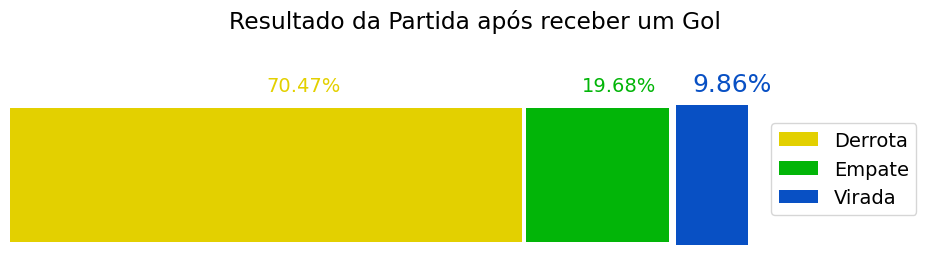

In [14]:
stack = df_3['virada'].value_counts(normalize=True).reset_index()

fig, ax = plt.subplots(1, 1, figsize = (10, 2))

left = 0
height = 0.8

for i, s in stack.iterrows():
    if i == 2:
        fontsize = 18
        left += 0.005
        height += 0.03
    else:
        fontsize = 14
    ax.barh('Resultado', s['virada'], label = s['index'], 
            left = left, color = color_lst[i], height = height)
    per = s['virada'] * 100
    string = f'{per:.2f}%'
    ax.text(x = s['virada'] / 2 + left*0.97, y = 0.5, s = string,
            fontsize = fontsize, color = color_lst[i])
    left +=(s['virada'] + 0.005)
    
ax.set_title('Resultado da Partida após receber um Gol',
            x = 0.6, y = 1.4)

ax.legend(['Derrota', 'Empate', 'Virada'],
          bbox_to_anchor=(0.97, 0.9))

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

Conforme esperado, vê-se que é muito difícil se recuperar de um gol recebido, tendo menos de 30% de ocorrências de não perda de um jogo. Mas uma questão pode ser levantada quanto a essa situação. O local influencia na virada?

In [15]:
mandante_virada = (df_3['mandante'] == df_3['vencedor']) & \
                  (df_3['mandante'] != df_3['time_primeiro_gol'])
mandante_empate = (df_3['vencedor'] == '-') & \
                  (df_3['mandante'] != df_3['time_primeiro_gol']) & \
                  (df_3['time_primeiro_gol'].notnull())
mandante_derrota = (df_3['mandante'] != df_3['vencedor']) & \
                   (df_3['mandante'] != df_3['time_primeiro_gol']) & \
                   (df_3['vencedor'] != '-')

In [16]:
visitante_virada = (df_3['visitante'] == df_3['vencedor']) & \
                   (df_3['visitante'] != df_3['time_primeiro_gol'])
visitante_empate = (df_3['vencedor'] == '-') & \
                   (df_3['visitante'] != df_3['time_primeiro_gol']) & \
                   (df_3['time_primeiro_gol'].notnull())
visitante_derrota = (df_3['visitante'] != df_3['vencedor']) & \
                    (df_3['visitante'] != df_3['time_primeiro_gol']) & \
                    (df_3['vencedor'] != '-')

In [17]:
mandante_visitante = pd.DataFrame(data = [[mandante_derrota.sum(), 
                                           visitante_derrota.sum()],
                     [mandante_empate.sum(), visitante_empate.sum()],
                     [mandante_virada.sum(), visitante_virada.sum()],
                    ],
             index = ['Derrota', 'Empate', 'Virada'],
             columns = ['Mandante', 'Visitante'])

mandante_visitante

,Mandante,Visitante
Derrota,720,1475
Empate,309,304
Virada,190,117


In [18]:
mandante_visitante['Mandante'] /= mandante_visitante['Mandante'].sum()
mandante_visitante['Visitante'] /= mandante_visitante['Visitante'].sum()

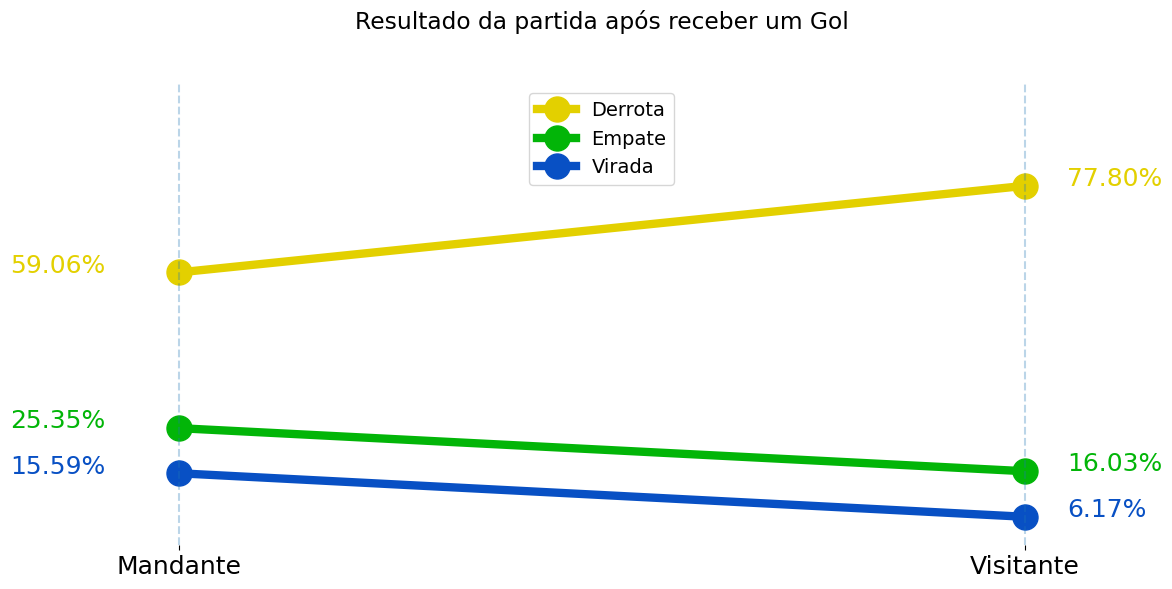

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

for j, (i, ss) in enumerate(mandante_visitante.iterrows()):
    ax.plot([0, 1], [ss['Mandante'], ss['Visitante']],
            marker = 'o', lw = 6, markersize = 18, color = color_lst[j], label = i)
    
    ax.text(x = 0 - 0.2, y = ss['Mandante'],
            s = '{:.2f}%'.format(ss['Mandante'] * 100),
            color = color_lst[j], fontsize = 18)
    
    ax.text(x = 1 + 0.05, y = ss['Visitante'],
            s = '{:.2f}%'.format(ss['Visitante'] * 100),
            color = color_lst[j], fontsize = 18)
    
ax.axvline(0, ls = '--', alpha = 0.3)
ax.axvline(1, ls = '--', alpha = 0.3)
    
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0, 1], ['Mandante', 'Visitante'], fontsize = 18)
ax.set_ylim(0, 1)

ax.tick_params(top=False,
               left=False,
               right=False,
               labelleft=False)

ax.set_title('Resultado da partida após receber um Gol', y = 1.1)

ax.legend();

Aqui, vê-se claramente que as ocorrências de Derrota aumentam drasticamente quando um time joga com visitante, assim como a redução das ocorrências de virada e empate.

## 6. Análise Temporal da Virada

Neste tópico, exploraremos a questão do tempo na virada, para ganhar insights de como uma virada ocorre, desde o primeiro gol recebido até o início da virada.

In [20]:
skew_vr = df_3['inicio_virada'].skew()
skew_pg = df_3['primeiro_gol'].skew()

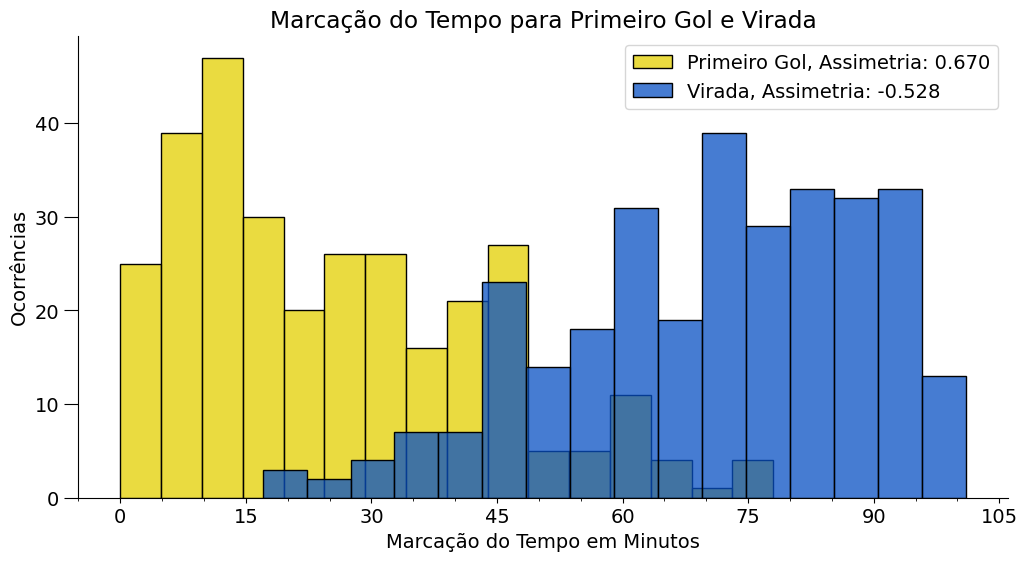

In [21]:
b = 16

fig, ax = plt.subplots(1, 1, figsize= (12, 6))
sns.histplot(data = df_3, x = 'primeiro_gol', edgecolor = 'k', color = color_lst[0], bins = b)
sns.histplot(data = df_3, x = 'inicio_virada',  edgecolor = 'k', color = color_lst[2], bins = b)

ax.set_title('Marcação do Tempo para Primeiro Gol e Virada')

ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend([f'Primeiro Gol, Assimetria: {skew_pg:.3f}', 
           f'Virada, Assimetria: {skew_vr:.3f}'], fontsize = 14);
ax.set_xlabel('Marcação do Tempo em Minutos')
ax.set_ylabel('Ocorrências');

Conforme esperado, o primeiro gol ocorre em sua maioria no primeiro tempo, e a virada ocorre no segundo. Vale ressaltar que há um maior número de viradas no primeiro tempo que primeros gols no segundo, notado pelo menor valor absoluto de assimetria. Na marcação próximo de 45 minutos, temos um salto no número de ocorrência de eventos. Isso se deve ao fato de termos desconsiderado o acréscimo de minutos no primeiro tempo, muito porque realmente mão temos como saber o tempo de acréscimo dado no primeiro tempo.

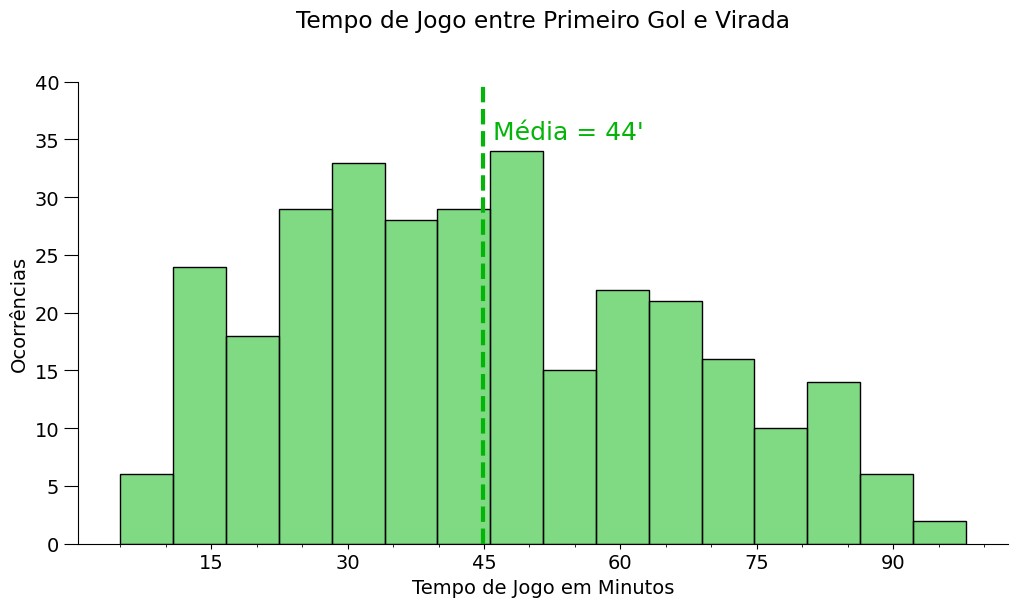

In [22]:
df_3['tempo_pra_virar'] = df_3['inicio_virada'] - df_3['primeiro_gol']

fig, ax = plt.subplots(1, 1, figsize= (12, 6))
sns.histplot(data = df_3, x = 'tempo_pra_virar', 
             ax = ax, edgecolor = 'k', 
             bins = 16, color = color_lst[1], alpha = 0.5);

mean = df_3['tempo_pra_virar'].mean()

ax.set_title('Tempo de Jogo entre Primeiro Gol e Virada', y = 1.1)

ax.axvline(mean, ls = '--', lw = 3, color = color_lst[1])
ax.text(46, 35, f'Média = {int(mean):2d}\'', fontsize = 18, color = color_lst[1])
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Tempo de Jogo em Minutos')
ax.set_ylabel('Ocorrências')
ax.set_ylim(0, 40);

Observamos uma distribuição visualmente normal de tempo de jogo entre o primeiro gol e o início da virada, tendo em média um valor de 44 minutos. Vale ressaltar que não estamos aqui considerando os acréscimos do primeiro tempo, portanto, o tempo de jogo pode ser muito maior o apresentado. 

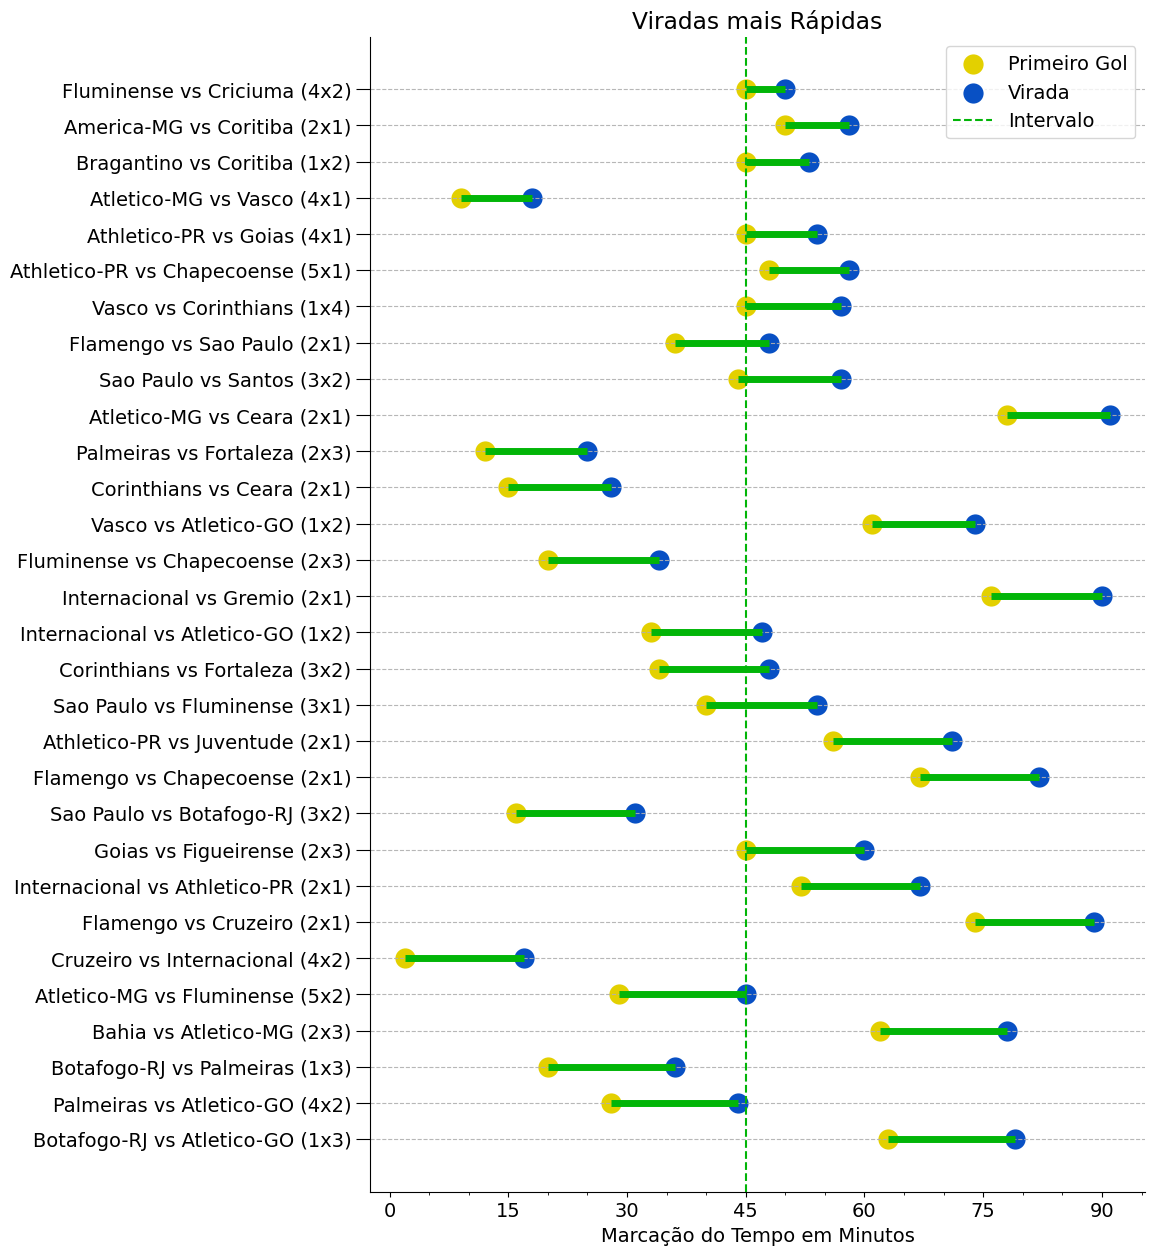

In [36]:
df_aux = df_3.sort_values(by = 'tempo_pra_virar', ascending = True).head(30)
df_aux['nome_partida'] = df_aux['mandante'] + ' vs ' + df_aux['visitante'] + \
                         ' (' + df_aux['mandante_Placar'].astype(str) + 'x' + \
                         df_aux['visitante_Placar'].astype(str) + ')'

y_range = np.arange(0, len(df_aux.index) + 0)


fig, ax = plt.subplots(1, 1, figsize = (10, 15))
plt.hlines(y = y_range, xmin = df_aux['primeiro_gol'],
           xmax = df_aux['inicio_virada'],
           color = color_lst[1], lw = 5)
sns.scatterplot(data=df_aux, y = 'nome_partida',
                x = 'primeiro_gol', ax = ax,
                color = color_lst[0], s = 250, label = 'Primeiro Gol')
sns.scatterplot(data=df_aux, y = 'nome_partida',
                x = 'inicio_virada', ax = ax,
                color = color_lst[2], s = 250, label = 'Virada')
ax.axvline(45, ls = '--', color = color_lst[1], label = 'Intervalo')
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(True, axis = 'y', alpha =0.9)
ax.set_xlabel('Marcação do Tempo em Minutos')
ax.set_ylabel('');
ax.set_title('Viradas mais Rápidas');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend();

No gráfico acima, podemos dar uma olhada nos eventos das viradas mais rápidas ao longo das partidas. Nota-se que não temos uma predominância quanto a ocorrência dos eventos exclusivamente ao primeiro ou segundo tempo.  

## 7. Jogadores Chave na Virada

Qual jogador é fundamental em uma situação prejudicial é uma questão muito mais complexa que a primeira vista. O papel de um jogador não se limita apenas a marcar gols, mas também a atuar bem com bom domínio de bola, posicionamento, passes certeiros e outros pontos difíceis de serem mensurados. Entretanto, só temos informações individuais de cartões e gols. Em razão disso, vamos assumir jogadores chave apenas os que marcaram gols em viradas.

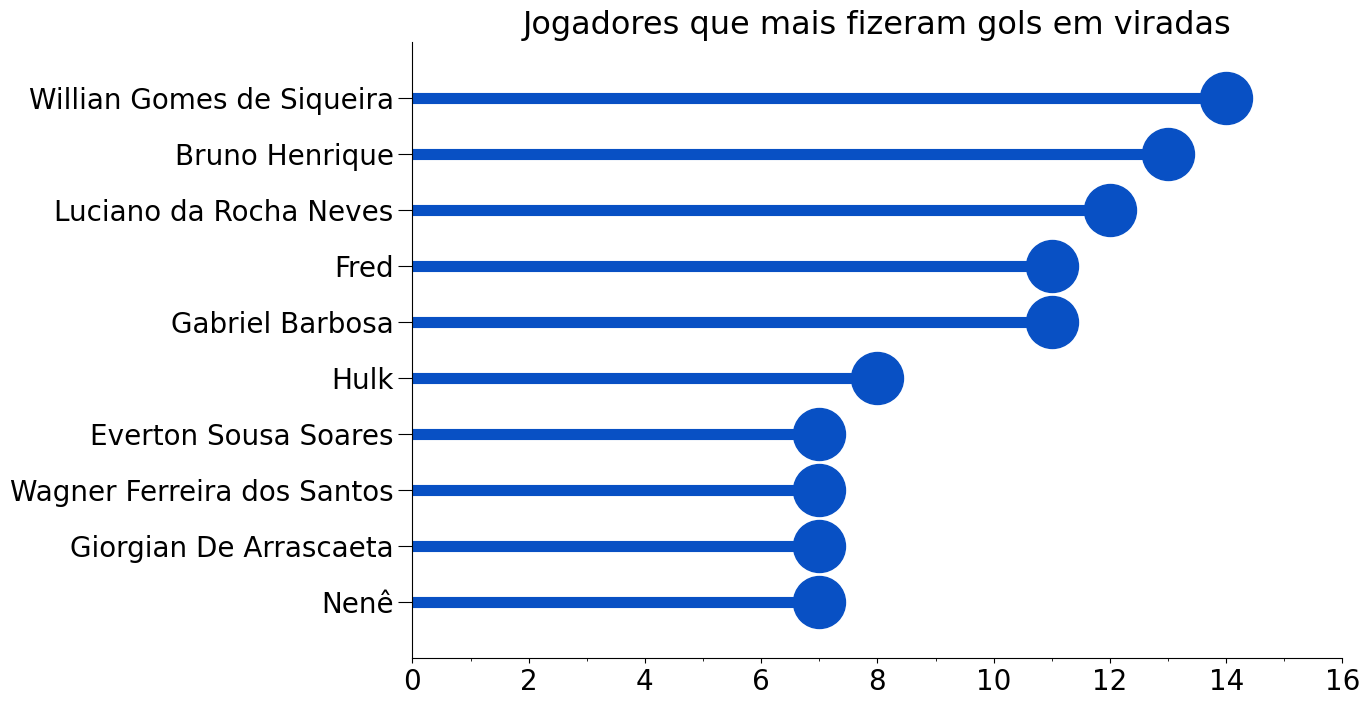

In [24]:
df_4 = df_4.merge(df_3[['partida_id', 'vencedor']], how = 'left', on = 'partida_id')
partidas_viradas = df_3.loc[df_3['virada'] == 1, 'partida_id']

mask = df_4['partida_id'].isin(partidas_viradas)
gols_virada = df_4[mask]

gols_contra = (gols_virada['tipo_de_gol'] == 'Gol Contra')
time_vencedor = (gols_virada['clube'] == gols_virada['vencedor'])


melhores_jogadores = gols_virada[(~gols_contra & time_vencedor)].groupby('atleta')\
                        .count().iloc[:, 1]\
                        .rename('gols_a_favor')\
                        .sort_values(ascending = False).head(10)


melhores_jogadores = melhores_jogadores.sort_values()

fig, ax = plt.subplots(1, 1, figsize = (12,  8))


m = melhores_jogadores.max()

ax.scatter(x = melhores_jogadores, y = melhores_jogadores.index,
           s = 1400, color = color_lst[2]);  

for i, mj in enumerate(melhores_jogadores):
    ax.plot([0, mj], [i, i], color = color_lst[2], lw = 8)

ax.set_title('Jogadores que mais fizeram gols em viradas', fontsize = 23)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))    
ax.tick_params(labelsize = 20)
ax.set_xlim(0, 16)
ax.set_ylim(-1, 10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

É esperado que os jogadores que mais fazem gols em viradas são jogadores que mais fazem gols no geral. Entretanto, Wagner, Everton e Hulk não estão presentes entre os trinta artilheiros do Brasileirão, conforme a lista abaixo. 

In [25]:
df_4['atleta'].value_counts().sort_values(ascending = False).head(30)

Gabriel Barbosa                   92
Fred                              81
Diego Souza                       80
Bruno Henrique                    59
Ricardo Oliveira                  56
Luciano da Rocha Neves            55
Eduardo Pereira Rodrigues         53
Willian Gomes de Siqueira         52
Gilberto Oliveira Souza Junior    50
Pedro                             48
Wellington Paulista               48
Giorgian De Arrascaeta            47
Rafael Moura                      46
Paolo Guerrero                    45
André Felipe Ribeiro de Souza     44
Mário Sérgio Santos Costa         43
Henrique Dourado                  42
Thiago Galhardo                   41
Eduardo Sasha                     40
Germán Cano                       40
Vinícius                          38
Pablo Felipe Teixeira             38
Keno                              38
Raphael Cavalcante Veiga          37
Leandro                           36
Everton Sousa Soares              36
Jô                                35
R

## 8. Melhores equipes, técnicos e formações para virar (os piores também)

Muitas vezes o equipe, técnico e formação pode ser melhor em uma situação prejudicial ou pior em uma situação favorável. A comunicação da equipe em situações difíceis, a habilidade de se manter calmo e uma formação robusta e flexível são essenciais para virar o jogo ou levar a um empate. Da mesma forma, a equipes que relaxam após fazer um gol, técnicos que não sabem manter a situação e formações pouco defensivas podem levar a perda de um jogo ganho. Por essa razão, vamos registrar a situação em que a equipe inicialmente se encontrava e o resultado final da partida.

In [26]:
tecnicos = pd.concat([df_3['tecnico_mandante'], 
                      df_3['tecnico_visitante']]).value_counts()
equipes = pd.concat([df_3['mandante'],
                     df_3['visitante']]).value_counts()
formacoes = pd.concat([df_3['formacao_mandante'],
                       df_3['formacao_visitante']]).value_counts()


lst_tecnicos = tecnicos.index
lst_equipes = equipes.index
lst_formacoes = formacoes.index

colunas = [
    'derrota-vitoria', 
    'derrota-derrota', 
    'derrota-empate', 
    'vitoria-vitoria',
    'vitoria-derrota', 
    'vitoria-empate']

df_tecnicos = pd.DataFrame(index = lst_tecnicos, columns = colunas)
df_formacao = pd.DataFrame(index = lst_formacoes, columns = colunas)
df_equipe = pd.DataFrame(index = lst_equipes, columns = colunas)

In [27]:
df_tecnicos = df_tecnicos.fillna(0)
df_formacao = df_formacao.fillna(0)
df_equipe = df_equipe.fillna(0)

In [28]:
def ocorrencias(df, mandante, visitante):

    for p in partidas:

        m = df_3.loc[df_3['partida_id'] == p, mandante].iat[0]
        v = df_3.loc[df_3['partida_id'] == p, visitante].iat[0]

        venc_clube = df_3.loc[df_3['partida_id'] == p, 'vencedor'].iat[0]
        gols = df_4.loc[df_4['partida_id'] == p, ['clube', 'minuto']].sort_values(by='minuto')
        primeiro_gol_clube = gols['clube'].iat[0]

        m_clube = df_3.loc[df_3['partida_id'] == p, 'mandante'].iat[0]

        if m_clube == primeiro_gol_clube:
            primeiro_gol = m
        else:
            primeiro_gol = v

        if venc_clube != '-':
            if m_clube == venc_clube:
                venc = m
            elif m_clube != venc_clube:
                venc = v
        
        else:
            venc = '-'

        for c in (m, v):
            if str(c) == 'nan':
                continue

            if c != primeiro_gol and c == venc:
                df.loc[c, 'derrota-vitoria'] += 1
            
            elif c != primeiro_gol and c != venc:
                if venc != '-':
                    df.loc[c, 'derrota-derrota'] += 1
                else:
                    df.loc[c, 'derrota-empate'] += 1

            elif c == primeiro_gol and c == venc:
                df.loc[c, 'vitoria-vitoria'] += 1
    
            elif c == primeiro_gol and c != venc:
                if venc != '-':
                    df.loc[c, 'vitoria-derrota'] += 1
                else:
                    df.loc[c, 'vitoria-empate'] += 1
    
    return df

df_equipe = ocorrencias(df_equipe, 'mandante', 'visitante')
df_tecnicos = ocorrencias(df_tecnicos, 'tecnico_mandante', 'tecnico_visitante')
df_formacao = ocorrencias(df_formacao, 'formacao_mandante', 'formacao_visitante')

Registrar o número de ocorrencias é importante, porém, por se tratar de um evento não muito recorrente, as frequências relativas nos trarão mais entendimento do evento.

In [29]:
def percentagem(df):
    df_per = df.copy()
    
    inicio_derrota = df.iloc[:, 0] + df.iloc[:, 1] + df.iloc[:, 2]
    inicio_vitoria = df.iloc[:, 3] + df.iloc[:, 4] + df.iloc[:, 5]
    
    for i in range(3):
        df_per.iloc[:, i] = df_per.iloc[:, i] / inicio_derrota
        df_per.iloc[:, i+3] = df_per.iloc[:, i+3] / inicio_vitoria
    
    return df_per, inicio_derrota, inicio_vitoria

df_equipe_per, equipe_id, equipe_iv = percentagem(df_equipe) 
df_tecnicos_per, tecnicos_id, tecnicos_iv = percentagem(df_tecnicos)
df_formacao_per, formacao_id, formacao_iv = percentagem(df_formacao)

Antes de fazermos comparações entre as equipes, tecnicos e formações, é importante verificar a distribuição do número de partidas. Qualquer desses três atributos podem apenas ter participado de poucas partidas, não tendo uma consistência em seus resultados. Podemos pensar que um técnico que virou 100% das partidas é melhor que um que virou 20%, mas participaram respectivamente de 10 e 100 partidas.

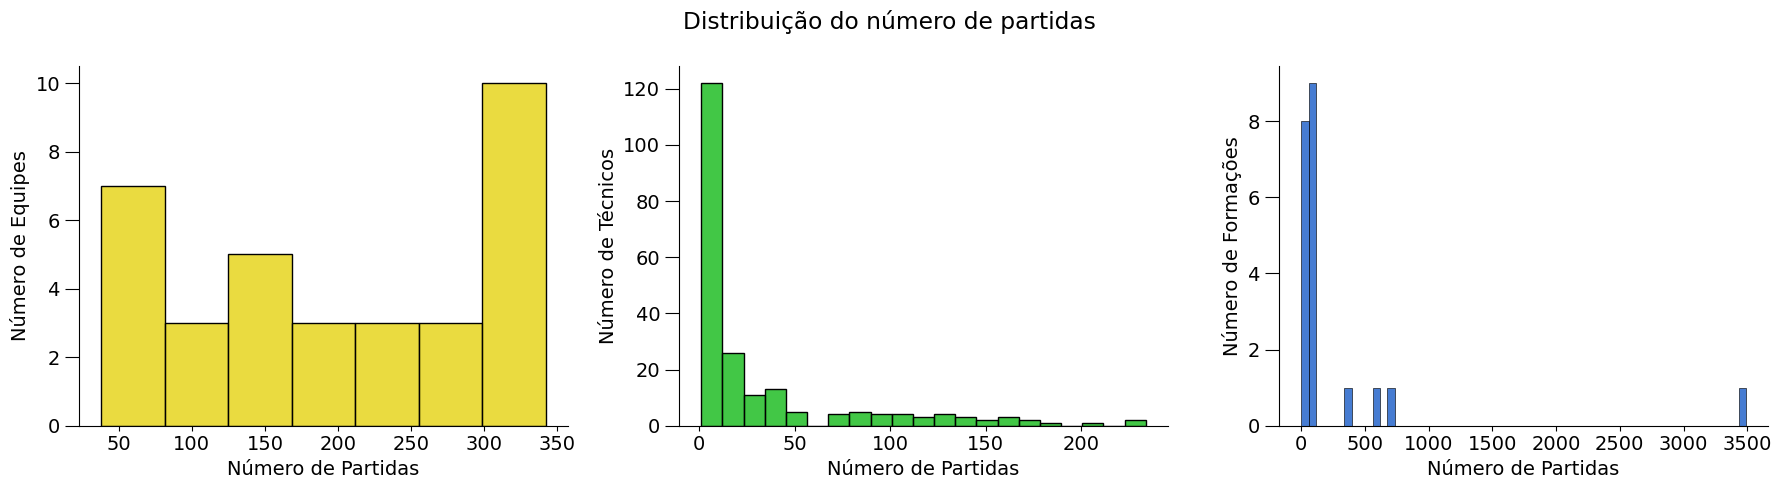

In [30]:
fig, ax = plt.subplots(1, 3, figsize = (18, 5))
sns.histplot(equipes, color = color_lst[0], edgecolor = 'k', ax = ax[0]);
sns.histplot(tecnicos, color = color_lst[1], edgecolor = 'k', ax = ax[1]);
sns.histplot(formacoes, color = color_lst[2], edgecolor = 'k', ax = ax[2]);


lst = ['Equipes', 'Técnicos', 'Formações']

fig.suptitle('Distribuição do número de partidas')

for i, r in enumerate(lst):
    ax[i].set_xlabel('Número de Partidas')
    ax[i].set_ylabel(f'Número de {r}')
    ax[i].spines['top'].set_visible(False);
    ax[i].spines['right'].set_visible(False);
    
fig.tight_layout()

A distribuição de equipes é de certa forma uniforme, enquanto que a distribuição de Técnicos e Formações são assimétrica a direita. Para analisar os dados, vamos rejeitar as instâncias abaixo de um quantil. O valor do quantil é definido subjetivamente, cabe ao analista definir o quanto uma equipe, técnico ou formação estão "maduros" o suficiente para serem analisados.

Vamos agora comparar as equipes, técnicos e formações mais bem sucedidos (iniciou o jogo perdendo mas conseguiu empatar ou virar) e os mals sucedidos (iniciou o jogo ganhando mas acabou empatando ou perdendo).

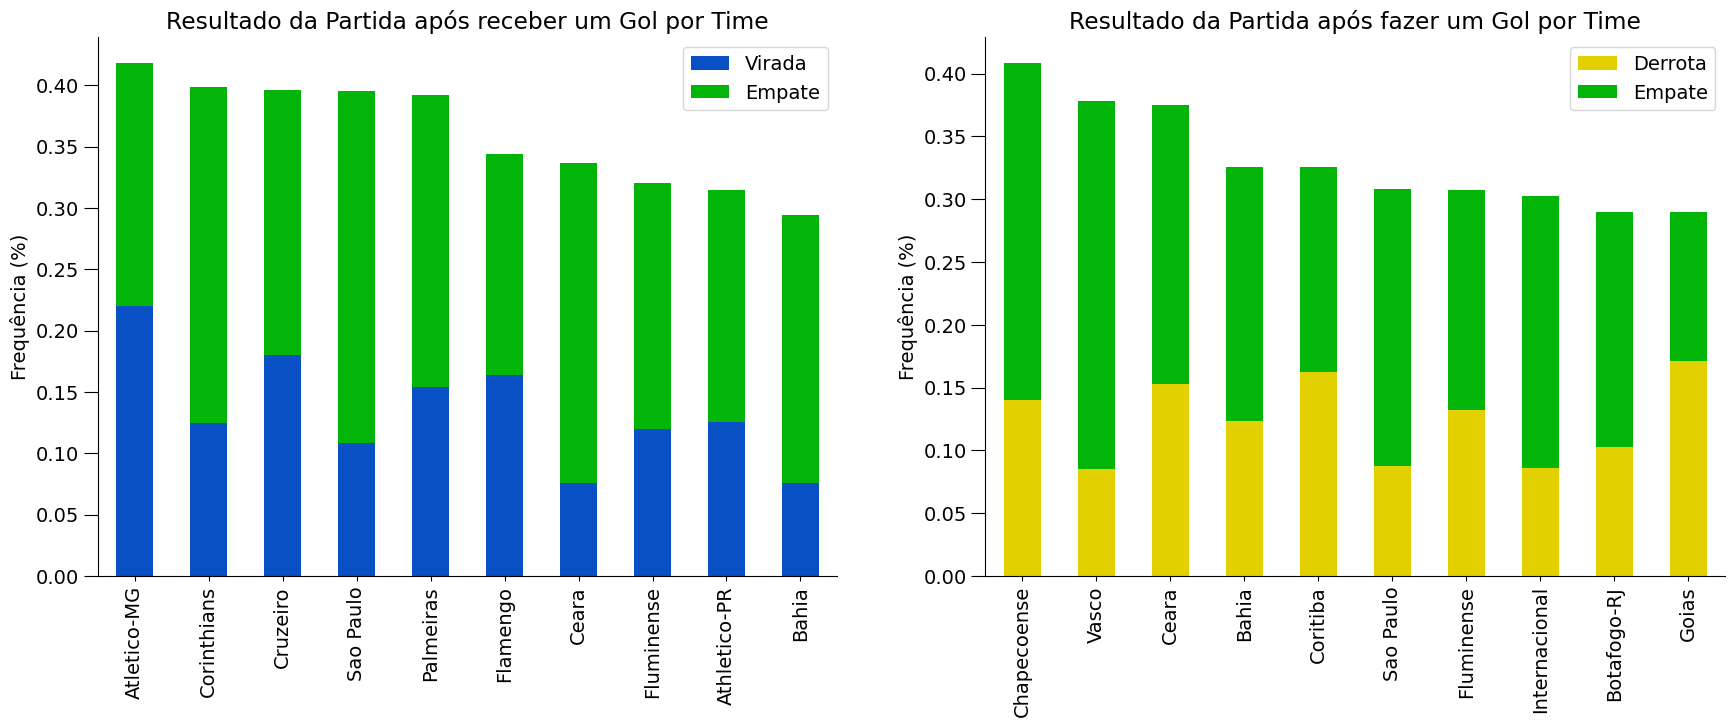

In [31]:
def stacked_plot(df, ocr, feats, label, th, colors, ax, title = '', resultados = 10):
    ind = ocr >= th
    order = df[feats[0]] + df[feats[1]]
    order = order.loc[ind].sort_values(ascending = False)
    
    #fig, ax = plt.subplots(1, 1, figsize = (12, 6))
    
    df.loc[order.index, feats].head(resultados).plot(kind = 'bar', stacked = True,
                                 ax = ax, color = colors)
    
    ax.legend(label)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel(f'Frequência (%)')
    
    ax.set_title(title)
    
    return

fig, ax = plt.subplots(1, 2, figsize = (21, 7))

stacked_plot(df_equipe_per, equipes,
             ['derrota-vitoria', 'derrota-empate'], 
             ['Virada', 'Empate'],
             th = equipes.quantile(0.5), colors = [color_lst[2], color_lst[1]],
             ax = ax[0],
             title = 'Resultado da Partida após receber um Gol por Time',
             resultados = 10)

stacked_plot(df_equipe_per, equipes,
             ['vitoria-derrota', 'vitoria-empate'], 
             ['Derrota', 'Empate'],
             th = equipes.quantile(0.5), colors = [color_lst[0], color_lst[1]],
             ax = ax[1],
             title = 'Resultado da Partida após fazer um Gol por Time',
             resultados = 10)

Atlético Mineiro não apenas possui o maior número de partidas bem-sucedidas, como tem o maior número de viradas. Cruzeiro é o Terceiro mais bem-sucedido e o segundo com mais viradas. Chapecoense é o Time com mais mal sucedido no que concerne não vencer um jogo que começou ganhando. Vemos que São Paulo, Fluminense, Ceará, Bahia estão nesta lista, apesar de configurarem na lista de mais bem sucedidos.

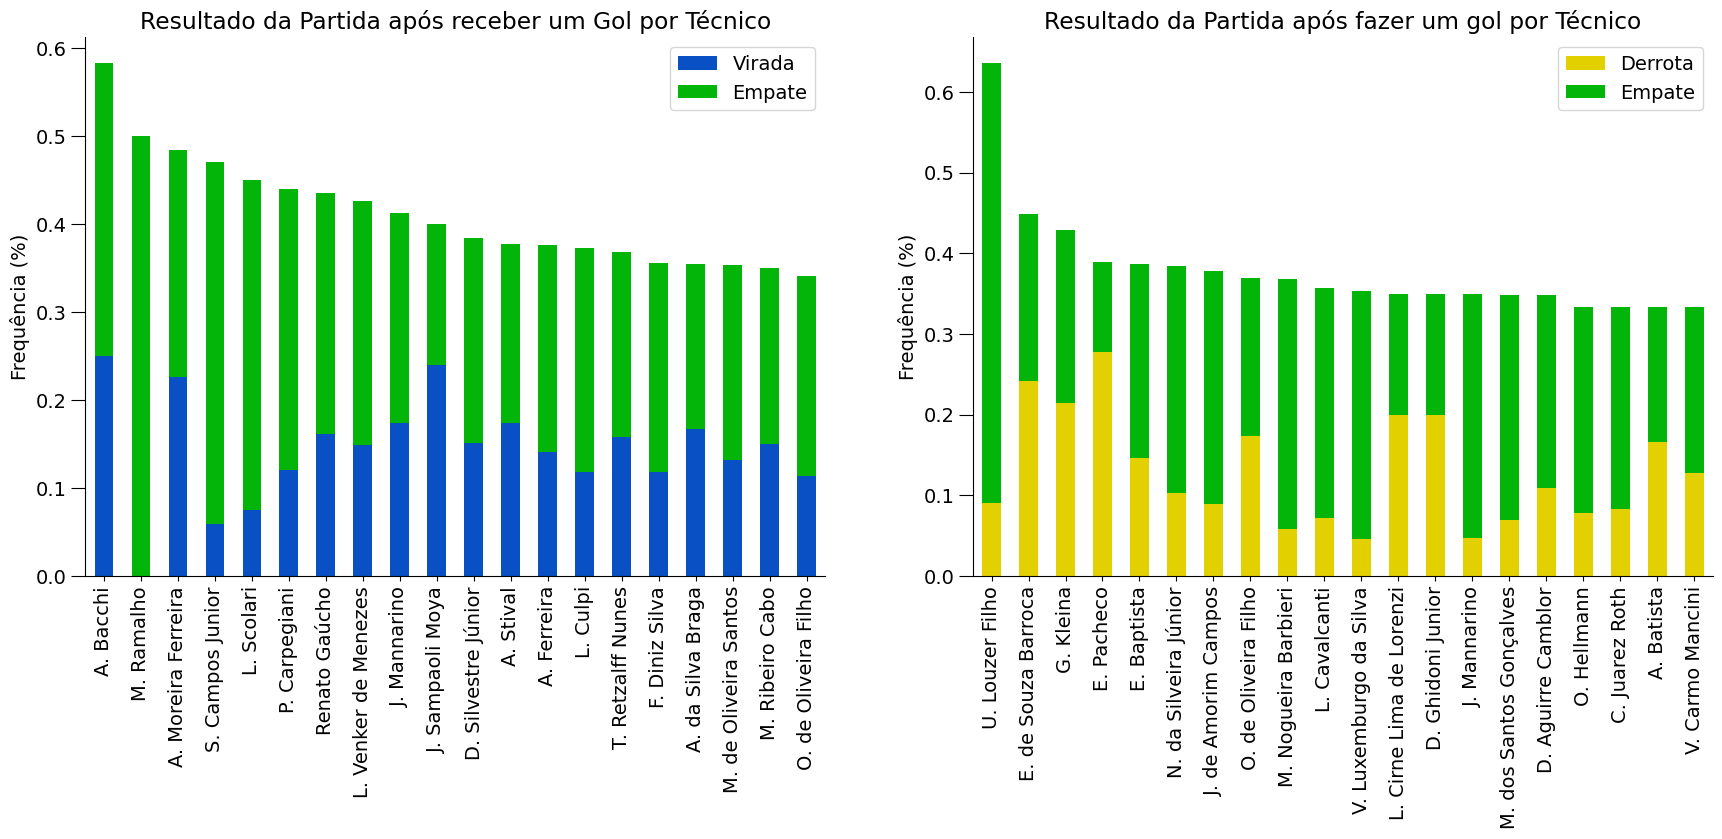

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))

stacked_plot(df_tecnicos_per, tecnicos,
             ['derrota-vitoria', 'derrota-empate'], 
             ['Virada', 'Empate'],
             th = tecnicos.quantile(0.75), colors = [color_lst[2], color_lst[1]],
             ax = ax[0],
             title = 'Resultado da Partida após receber um Gol por Técnico',
             resultados = 20)

stacked_plot(df_tecnicos_per, tecnicos,
             ['vitoria-derrota', 'vitoria-empate'], 
             ['Derrota', 'Empate'],
             th = tecnicos.quantile(0.75), colors = [color_lst[0], color_lst[1]],
             ax = ax[1],
             title = 'Resultado da Partida após fazer um gol por Técnico',
             resultados = 20)

Tite (A. Bacchi) é o treinador que mais aproveitou situações não favoráveis, tendo mais chances em virar uma situação favorável de uma desfavorável. Destaca-se Muricy Ramalho que, apesar de não virar nenhum jogo, garantiu empate para metade dos jogos em desvantagem. Louzer Filho, E. de Souza e G. Kleina não souberam aproveitar muito bem a vantagem, tendo Louzer perdendo a maioria dos jogos.

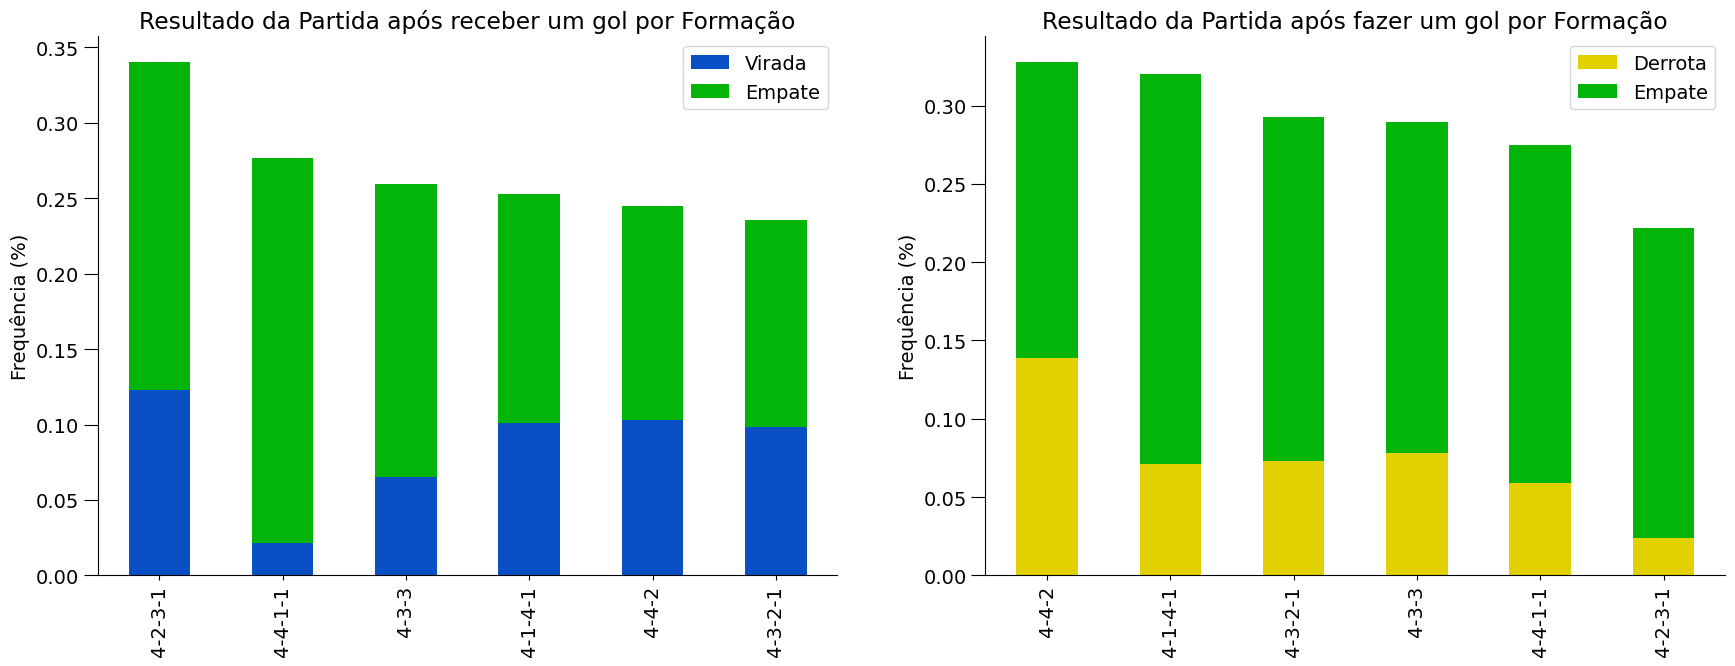

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))

stacked_plot(df_formacao_per, formacoes,
             ['derrota-vitoria', 'derrota-empate'],
             ['Virada', 'Empate'],
             ax = ax[0],
             th =  formacoes.quantile(0.75), colors = [color_lst[2], color_lst[1]],
             title = 'Resultado da Partida após receber um gol por Formação')

stacked_plot(df_formacao_per, formacoes,
             ['vitoria-derrota', 'vitoria-empate'], 
             ['Derrota', 'Empate'],
             ax = ax[1],
             th = formacoes.quantile(0.75), colors = [color_lst[0], color_lst[1]],
             title = 'Resultado da Partida após fazer um gol por Formação')

Um ponto interessante a se levantar: a formação 4-2-3-1 é a mais popular por uma vasta margem, com 57% das ocorrências. Não é de se estranhar que seja a mais bem sucedida tanto em viradas como em viradas mais empates. Vemos o mesmo padrão ocorrendo para situações em desvantagem.

In [34]:
formacoes / formacoes.sum()

4-2-3-1      0.571452
4-1-4-1      0.116028
4-3-3        0.099476
4-4-2        0.061291
4-4-1-1      0.016880
4-3-2-1      0.016880
4-2-2-2      0.015241
3-4-1-2      0.015077
4-3-1-2      0.013438
3-4-2-1      0.012455
3-4-3        0.011963
5-4-1        0.010652
4-1-2-1-2    0.010488
3-5-2        0.007047
4-5-1        0.005736
4-2-4-0      0.004097
3-1-4-2      0.003605
5-3-2        0.003605
4-1-3-2      0.003441
3-5-1-1      0.000656
3-2-4-1      0.000492
dtype: float64

## 9. Correlação entre eventos

Ao se levantar os eventos mal-sucedidos e bem-sucedidos, torna-se atrativa a ideia de se verificar se há correlação linear entre ambos. Times que conseguem ser bem-sucedidos situação de desvantagem podem não ser tão mal-sucedidos, por exemplo. Uma forma de verificar é pela correlação de pearson em conjunto o gráfico de dispersão.

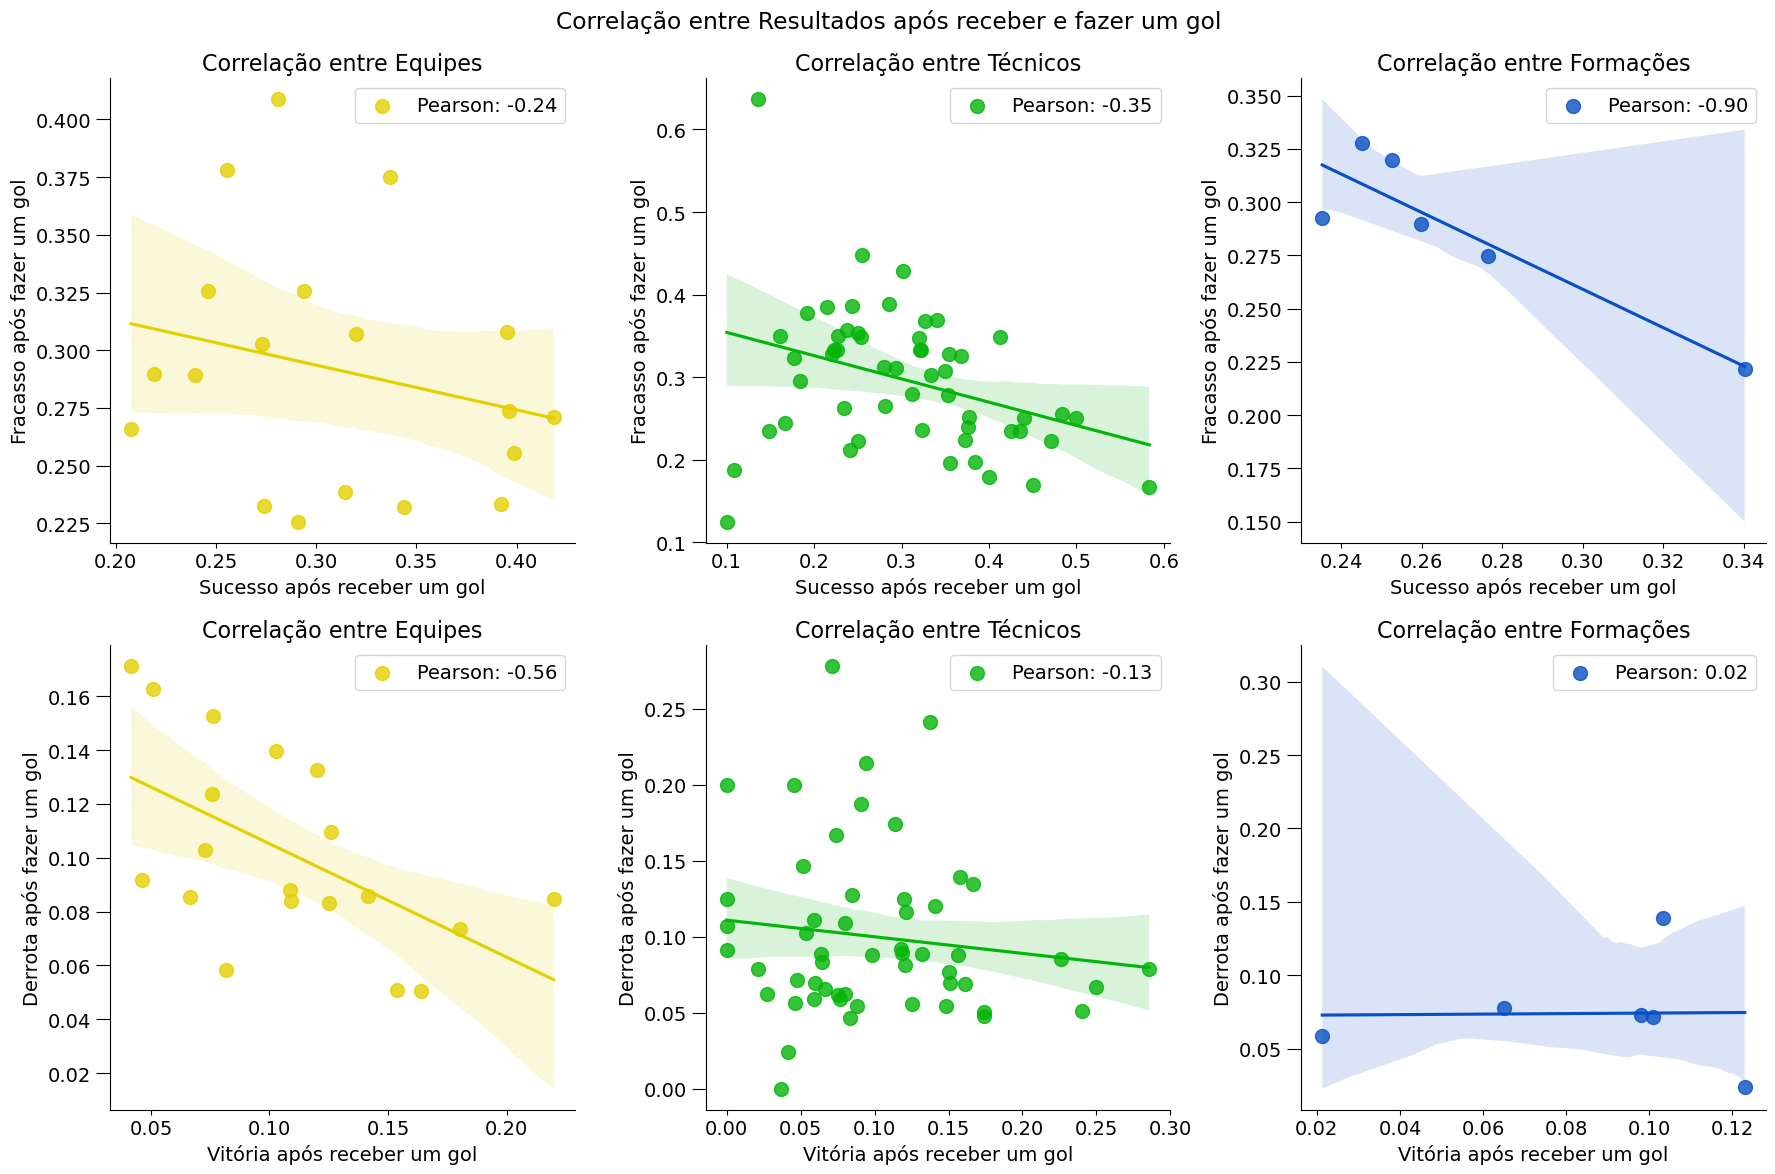

In [35]:
th_e = equipes.quantile(0.5)
th_t = tecnicos.quantile(0.75)
th_f = formacoes.quantile(0.75)

fig, ax = plt.subplots(2, 3, figsize = (18, 12))

dic = {
    'Equipes': (df_equipe_per, equipes, th_e),
    'Técnicos': (df_tecnicos_per, tecnicos, th_t),
    'Formações': (df_formacao_per, formacoes, th_f)
}

fig.suptitle('Correlação entre Resultados após receber e fazer um gol')

for i, (k, v) in enumerate(dic.items()):
    df = v[0]
    valid = v[1] >= v[2]
    df = df.loc[valid]
    
    df_ = pd.DataFrame(data = np.zeros((len(df.index), 2)),
                       columns = ['bem-sucedido', 'mal-sucedido'],
                       index = df.index)
    
    
    df_.iloc[:, 0] = df.iloc[:, 0] + df.iloc[:, 2]
    df_.iloc[:, 1] = df.iloc[:, 4] + df.iloc[:, 5]
    
    c1 = np.corrcoef(df_['bem-sucedido'], df_['mal-sucedido'])[0, 1]
    c2 = np.corrcoef(df['derrota-vitoria'], df['vitoria-derrota'])[0, 1]
    
    sns.regplot(data = df_, x = 'bem-sucedido', y = 'mal-sucedido', ax = ax[0, i], color = color_lst[i], label = f'Pearson: {c1:.2f}')
    sns.regplot(data = df, x = 'derrota-vitoria', y = 'vitoria-derrota', ax = ax[1, i], color = color_lst[i], label = f'Pearson: {c2:.2f}')
    
    ax[0, i].set_title(f'Correlação entre {k}', fontsize = 16)
    ax[0, i].set_xlabel('Sucesso após receber um gol')
    ax[0, i].set_ylabel('Fracasso após fazer um gol')
    ax[0, i].spines['top'].set_visible(False);
    ax[0, i].spines['right'].set_visible(False);
    ax[0, i].legend()
    
    ax[1, i].set_title(f'Correlação entre {k}', fontsize = 16)
    ax[1, i].set_xlabel('Vitória após receber um gol')
    ax[1, i].set_ylabel('Derrota após fazer um gol')
    ax[1, i].spines['top'].set_visible(False);
    ax[1, i].spines['right'].set_visible(False);
    ax[1, i].legend()
    
fig.tight_layout()

Temos uma forte correlação negativa entre o fracasso e sucesso da Formação,  e uma moderada correlação considerando os Técnicos. Um ponto interessante é que a correlação entre derrotas e vitórias entre Equipes, o qual é maior que a correlação entre fracasso e sucesso.

## 10. Considerações Finais

Após a análise das viradas no Brasileirão, destacamos pontos fundamentais. As viradas são são frequentes, ocorrendo mais com equipes mandantes que visitantes. A duração da virada varia, ocorrendo em diferentes momentos do jogo. Apesar de não termos informações sobre outras estatíticas individuais dos jogadores, foi possível destacar jogadores mais importantes para a virada. Algumas equipes têm mais sucesso em viradas do que outras, assim como certos treinadores e formações táticas, e como esse sucesso está negativamente correlacionado com seu fracasso. Esses insights revelam a imprevisibilidade do futebol e a complexidade de fatores envolvidos. O Brasileirão continua sendo uma competição emocionante e surpreendente, com viradas dramáticas que mantêm a paixão pelo esporte viva